In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
movies = pd.read_csv('../../data/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
ratings = pd.read_csv('../../data/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('../../data/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], encoding='ISO-8859-1')

In [4]:
users = users.drop(["zip_code"], axis = 1)

In [5]:
# Create age groups
bins = [0, 18, 25, 35, 45, 50, 56, np.inf]
ages = ['<18', '18-24', '24-34','35-44', '45-49', '50-55', '56+']
users['age_group'] = pd.cut(users['age'], bins, labels=ages)
users = users.drop(["age"], axis = 1)

occupation_map = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Map the occupation IDs to occupation names in the users dataframe
users['occupation'] = users['occupation'].map(occupation_map)

users.head()

,user_id,gender,occupation,age_group
0,1,F,K-12 student,<18
1,2,M,self-employed,50-55
2,3,M,scientist,18-24
3,4,M,executive/managerial,35-44
4,5,M,writer,18-24


In [6]:
# Generate user features as a sparse matrix
columnsToEncode = ['age_group','gender','occupation']
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(users[columnsToEncode])

user_features = pd.concat([users.drop(columnsToEncode, 1), 
                           pd.DataFrame(myEncoder.transform(users[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()

user_features.head()

,user_id,age_group_18-24,age_group_24-34,age_group_35-44,age_group_45-49,age_group_50-55,age_group_<18,gender_F,gender_M,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,occupation_farmer,occupation_homemaker,occupation_lawyer,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer
0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Content Filtering to Generate Arms

In [7]:
def generate_arms(movies, ratings, user_id):

    # Define the TfidfVectorizer
    tfidf = TfidfVectorizer(stop_words='english')

    # Fit and transform the genres column of the movies dataframe
    movies_genres_tfidf = tfidf.fit_transform(movies['genres'])

    # Compute the user preference vectors
    user_preferences = ratings[(ratings['user_id'] == user_id)]
    user_preferences = user_preferences.merge(movies, on='movie_id')
    user_preferences_genres_tfidf = tfidf.transform(user_preferences['genres'])
    user_preference_vector = user_preferences_genres_tfidf.sum(axis=0)

    # Convert the user preference vector to a numpy array
    user_preference_vector = np.array(user_preference_vector).reshape(-1)

    # Compute the cosine similarity between the user preference vector and the movie feature vectors
    similarity_scores = cosine_similarity(user_preference_vector.reshape(1, -1), movies_genres_tfidf)

    # Get the row indices of the top n movies with the highest similarity scores
    n = 30
    top_movie_indices = similarity_scores.argsort()[0][-n:][::-1]

    # Get the corresponding movie ids and titles
    top_movie_ids = [movies.iloc[i]['movie_id'] for i in top_movie_indices]

    return top_movie_ids

In [8]:
user_id = 4169
arms = generate_arms(movies, ratings, user_id)
arms

[205,
 2238,
 1115,
 3500,
 476,
 3504,
 3778,
 3506,
 2577,
 472,
 1133,
 2156,
 1146,
 3255,
 1642,
 3526,
 3045,
 1630,
 72,
 1622,
 2504,
 3537,
 3060,
 3543,
 3067,
 133,
 1701,
 2596,
 2977,
 2961]

In [9]:
# One-hot encoding for genres
genres = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies, genres],axis=1).drop(columns={'genres'})
df = movies.merge(ratings,how='left',on='movie_id')

In [10]:
movies.shape

(3883, 20)

In [11]:
df.shape

(1000386, 23)

In [12]:
# Generate movie features as a sparse matrix
movie_features = movies.drop(['title'],axis = 1)
movie_features

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [13]:
arm_movies_features = movie_features[movie_features.movie_id.isin(arms)]
arm_movies_features

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
71,72,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
131,133,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
203,205,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
468,472,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
472,476,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1099,1115,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1117,1133,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1130,1146,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1579,1622,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1587,1630,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
arm_movies_features.to_numpy().shape

(30, 19)

In [15]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [16]:
filtered_data_original = ratings[ratings["movie_id"].isin(arms)]

filtered_data_original.head()

,user_id,movie_id,rating,timestamp
90,2,3255,4,978299321
568,8,3500,3,978232754
608,8,1701,4,978231659
639,8,476,3,978230687
765,9,3255,4,978226216


In [17]:
filtered_data_original["reward"] = np.where(filtered_data_original["rating"] < 4,0,1)

filtered_data_original = filtered_data_original.reset_index(drop = True)

In [18]:
filtered_data_original.head()

,user_id,movie_id,rating,timestamp,reward
0,2,3255,4,978299321,1
1,8,3500,3,978232754,0
2,8,1701,4,978231659,1
3,8,476,3,978230687,0
4,9,3255,4,978226216,1


In [19]:
reward_mean = filtered_data_original.reward.mean()
reward_mean

0.5946422842476741

In [20]:
# Reshuffling rows to randomise it
np.random.seed(100)
filtered_data = filtered_data_original.reindex(np.random.permutation(filtered_data_original.index)).reset_index(drop = True)

In [21]:
filtered_data

,user_id,movie_id,rating,timestamp,reward
0,3430,1701,4,969151051,1
1,1532,2961,5,974825278,1
2,1207,3255,2,974845947,0
3,4448,3067,4,966285933,1
4,625,3255,4,975787015,1
...,...,...,...,...,...
6229,5880,3526,4,957545078,1
6230,96,3526,5,980563301,1
6231,3971,3255,4,967070109,1
6232,5830,3537,4,957891714,1


### LinUCB Disjoint Simulation

In [22]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x_array) +  self.alpha * np.sqrt(np.dot(x_array.T, np.dot(A_inv,x_array)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x_array

In [23]:
class linucb_disjoint_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm
    
    def store_arm_index(self, arms_index_array):
    # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index

        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):

            self.linucb_arms[i].arm_index = arms_index_array[i]

In [24]:
def ctr_disjoint_simulator(K_arms, d, alpha, epochs, top_movies_index, steps_printout):
    # Initiate policy
    linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Store specific arm_index
    linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    log_step = []
    play_step = []
    arm_chosen = []
    reward = []
    cumulative_reward = 0
    cumulative_rewards = []
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    for epoch_iter in range(epochs):
        
        print("Epoch: " + str(epoch_iter))
        
        if epoch_iter == 0:
            # Start with filtered data first
            data = filtered_data.copy()
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        else:
            
            # Recycle unused data
            data = unused_data.copy().reset_index(drop = True)
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        
        for i in range(data.shape[0]):

            user_id = data.loc[i,"user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i%steps_printout == 0:
                print("step "+str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array)
                
                # For CTR calculation
                aligned_time_steps += 1
                log_step.append(i+1)
                play_step.append(aligned_time_steps)
                arm_chosen.append(movie_id)
                reward.append(data_reward)
                cumulative_reward += data_reward
                cumulative_rewards.append(cumulative_reward)
                aligned_ctr.append(cumulative_reward/aligned_time_steps)
            
            else:
                # Recycle data
                unused_data = unused_data.append(data.iloc[i])
                    
    return pd.DataFrame(
            {"log_step": log_step,
            "play_step": play_step,
            "arm_chosen": arm_chosen,
            "reward": reward, 
            "cumulative_rewards": cumulative_rewards, 
            "aligned_ctr": aligned_ctr, 
            "policy": "linucb_disjoint_policy"}
            )

### LinUCB Hybrid

In [25]:
class linucb_hybrid_arm():
    # Note that shared features coefficients beta_hat is calculated outside of each arm since 
    # it is about shared features across individual arms
    
    def __init__(self, d, k, alpha):
        
        # Arm specific A: (d * d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # B: (d * k) matrix
        # Equals to D_a.T * c_a in ridge regression formulation
        self.B = np.zeros([d, k])
        
        # b: (d * 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
        # Alpha hyperparam
        self.alpha = alpha
        
    def init_arm_features(self, arm_index, arm_features_array):
        # Track arm_index
        self.index = arm_index
        
        # arm_features to be used with x_array using outer product to find individual arm z_features
        self.arm_features = arm_features_array
        
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        # beta_hat is the coefficients for Z shared features. (k * 1) vector
        # A_node_inv is (k * k) matrix that is inverse for A_node (shared features)
        
        # Create arm specific z_array with x_array and self.arm_features
        # z_array elements is based on the combination of user and movie features, which is the outer product of both arrays
        # z_array = Outer product = (19 * 29) or (k by d) matrix
        z_array = np.outer(self.arm_features, x_array).reshape(-1,1)
        
        # Find inverse of arm-specific A
        A_inv = np.linalg.inv(self.A)
        
        # Find theta_arm with beta_hat input
        self.theta = np.dot(A_inv, (self.b - np.dot(self.B, beta_hat)))
        
        # std deviation
        s = np.dot(z_array.T, np.dot(A_node_inv, z_array)) \
            - 2 * np.dot(z_array.T, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array)))) \
            + np.dot(x_array.T, np.dot(A_inv, x_array)) \
            + np.dot(x_array.T, np.dot(A_inv, np.dot(self.B, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array))))))
        
        
        # UCB
        p = np.dot(z_array.T, beta_hat) + np.dot(x_array.T, self.theta) + self.alpha*np.sqrt(s)
        
        return p
    
    def reward_update(self, reward, x_array, z_array):
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)
        
        # Update B which is (d * k) matrix.
        self.B += np.dot(x_array, z_array.T)
        
        # Update b which is (d * 1) vector
        # reward is scalar
        self.b += reward * x_array 

In [26]:
class linucb_hybrid_policy():
    
    def __init__(self, K_arms, d, k, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d = d, k = k, alpha = alpha) for i in range(K_arms)]
        
        # shared A_node: (k * k) matrix
        self.A_node = np.identity(k)
        
        # shared b_node: (k * 1) corresponding response vector. 
        self.b_node = np.zeros([k,1])
        
    def store_arm_features(self, arms_features_array):
        # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index
    
        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):
        
            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i,0], 
                                                  arm_features_array = arms_features_array[i,1:])
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Create inverse of A_node to be fed in
        A_node_inv = np.linalg.inv(self.A_node)
        
        
        # Calc beta_hat using A_node_inv and b_node.
        # (k * 1) vector
        beta_hat = np.dot(A_node_inv, self.b_node)
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array, A_node_inv, beta_hat)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm_index = np.random.choice(candidate_arms)
        
        return chosen_arm_index
    
    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        # Use chosen arm's B (d*k), A(d*d), b(k*1) for update of shared feature matrices
        
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        self.A_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        self.b_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))
        
    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        self.A_node += np.dot(z_array, z_array.T) - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B)) 
        self.b_node += reward * z_array - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

In [27]:
def ctr_simulator(K_arms, d, k, alpha, epochs, top_movies_index, top_movies_features, steps_printout):
    # Initiate policy
    linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms = K_arms, d = d, k = k, alpha = alpha)
    
    # Store arm specific features
    linucb_hybrid_policy_object.store_arm_features(top_movies_features.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    log_step = []
    play_step = []
    arm_chosen = []
    reward = []
    cumulative_reward = 0
    cumulative_rewards = []
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    for epoch_iter in range(epochs):
        
        print("Epoch: " + str(epoch_iter))
        
        if epoch_iter == 0:
            # Start with filtered data first
            data = filtered_data.copy()
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        else:
            
            # Recycle unused data
            data = unused_data.copy().reset_index(drop = True)
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        
        for i in range(data.shape[0]):

            user_id = data.loc[i,"user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i%steps_printout == 0:
                print("step "+str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(data_x_array)


            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index  == movie_id:


                # Phase 1: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)
                
                # Extract chosen_arm arm_features to create z_array
                data_z_array = np.outer(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, data_x_array).reshape(-1,1)
                
                # Use reward information for the chosen arm to update
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array, data_z_array)

                # Phase 2: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(data_z_array,
                                                                                   data_reward,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # For CTR calculation
                aligned_time_steps += 1
                log_step.append(i+1)
                play_step.append(aligned_time_steps)
                arm_chosen.append(movie_id)
                reward.append(data_reward)
                cumulative_reward += data_reward
                cumulative_rewards.append(cumulative_reward)
                aligned_ctr.append(cumulative_reward/aligned_time_steps)
            
            else:
                # Recycle data
                unused_data = unused_data.append(data.iloc[i])

    return pd.DataFrame(
            {"log_step": log_step,
            "play_step": play_step,
            "arm_chosen": arm_chosen,
            "reward": reward, 
            "cumulative_rewards": cumulative_rewards, 
            "aligned_ctr": aligned_ctr, 
            "policy": "linucb_hybrid_policy"}
            )

In [28]:
alpha_value = 0.25
simulation_disjoint_alpha_025 = ctr_disjoint_simulator(K_arms = 30, 
                                                       d = 29,
                                                       alpha = alpha_value, 
                                                       epochs = 2, 
                                                       top_movies_index = pd.DataFrame(arms), 
                                                       steps_printout=5000)

Epoch: 0
step 0
step 5000
Epoch: 1
step 0
step 5000


In [29]:
alpha_value = 0.25
simulation_hybrid_alpha_025 = ctr_simulator(K_arms = 30, 
                                           d = 29,
                                           k = 29*18,
                                           alpha = alpha_value, 
                                           epochs = 2, 
                                           top_movies_index = arms, 
                                           top_movies_features= arm_movies_features,
                                           steps_printout=5000)

Epoch: 0
step 0
step 5000
Epoch: 1
step 0
step 5000


### Average Rewards Over Time

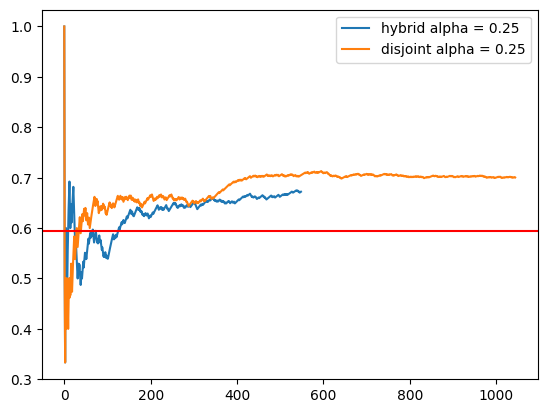

In [30]:
plt.plot(simulation_hybrid_alpha_025["aligned_ctr"], label = "hybrid alpha = 0.25")
plt.plot(simulation_disjoint_alpha_025["aligned_ctr"], label = "disjoint alpha = 0.25")
plt.axhline(y=reward_mean, color = "red")
plt.legend()

### Cumulative Rewards Over Time

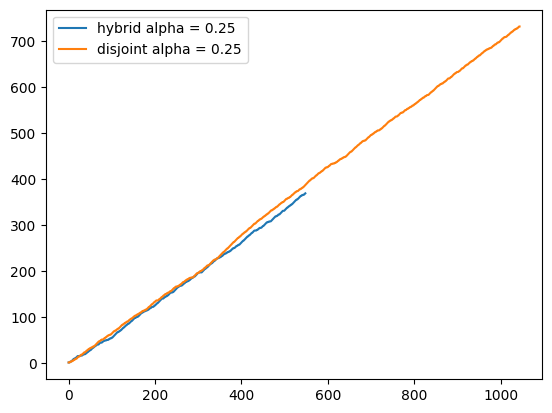

In [31]:
plt.plot(simulation_hybrid_alpha_025["cumulative_rewards"], label = "hybrid alpha = 0.25")
plt.plot(simulation_disjoint_alpha_025["cumulative_rewards"], label = "disjoint alpha = 0.25")
plt.legend()

### Probability of Choosing Best Arm Over Time

Text(0.5, 1.0, 'Probability of Choosing the Best Arm')

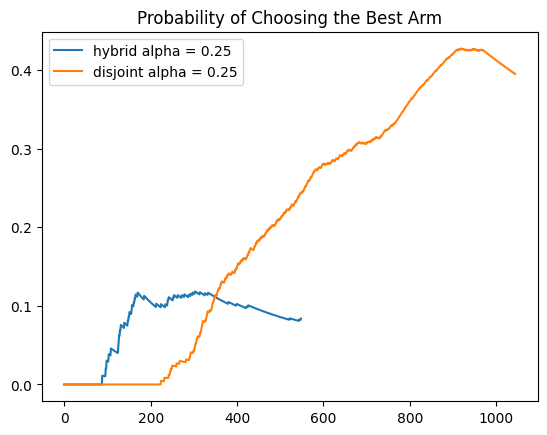

In [32]:
best_arm_disjoint = simulation_disjoint_alpha_025.groupby('arm_chosen').reward.mean().idxmax()

simulation_disjoint_alpha_025['if_best_arm'] = np.where(simulation_disjoint_alpha_025['arm_chosen']==best_arm_disjoint, 1,0)

best_arm_hybrid = simulation_hybrid_alpha_025.groupby('arm_chosen').reward.mean().idxmax()

simulation_hybrid_alpha_025['if_best_arm'] = np.where(simulation_hybrid_alpha_025['arm_chosen']==best_arm_hybrid, 1,0)

# plot for the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(simulation_hybrid_alpha_025['if_best_arm'].cumsum() / np.arange(1, len(simulation_hybrid_alpha_025['if_best_arm']) + 1), label = "hybrid alpha = 0.25")
ax.plot(simulation_disjoint_alpha_025['if_best_arm'].cumsum() / np.arange(1, len(simulation_disjoint_alpha_025['if_best_arm']) + 1), label = "disjoint alpha = 0.25")
plt.legend()
plt.title('Probability of Choosing the Best Arm')

### Regret Comparison

In [33]:
ratings["like"] = (ratings["rating"] >= 4).astype(int)

df_by_count = ratings.groupby("movie_id").agg(count=("rating", pd.Series.count), 
                                       mean=("rating", pd.Series.mean), 
                                       like_count=("like",pd.Series.sum)).sort_values(by="count", ascending=False)
df_by_count["like_prob"] = df_by_count["like_count"] / df_by_count["count"]
df_by_count.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


In [35]:
top_30_agg = df_by_count[df_by_count.index.isin(arms)]

In [42]:
# Optimal Results
optimal_movie = np.argmax(top_30_agg["like_prob"].tolist())
optimal_cum_reward = top_30_agg["like_prob"].tolist()[optimal_movie]
optimal_cum_reward

0.7311046511627907

In [43]:
# Compare Algo to Optimal
algo_name = ["LinUCB Disjoint", "LinUCB Hybrid"]
cum_reward_mean = []
regret_percent = []

# Average Reward
mean_disjoint = simulation_disjoint_alpha_025['aligned_ctr'].iloc[-1]
cum_reward_mean.append(mean_disjoint)
mean_hybrid = simulation_hybrid_alpha_025['aligned_ctr'].iloc[-1]
cum_reward_mean.append(mean_hybrid)

# Calculate Regret
regret_disjoint = round((optimal_cum_reward - mean_disjoint) / optimal_cum_reward, 2)
regret_percent.append(regret_disjoint)
regret_hybrid = round((optimal_cum_reward - mean_disjoint) / optimal_cum_reward, 2)
regret_percent.append(regret_hybrid)
    
data = {
    'Algorithm Name': algo_name,
    'Cummulative Reward': cum_reward_mean,
    'Regret Percentage': regret_percent
}

regret_df = pd.DataFrame(data)
regret_df

,Algorithm Name,Cummulative Reward,Regret Percentage
0,LinUCB Disjoint,0.700478,0.04
1,LinUCB Hybrid,0.672131,0.04
